# 1.0 - IMPUTANDO VALORES PARA OS AUSENTES DA CARACTERÍSTICA PAY_1

In [2]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import graphviz
import warnings
import inflection

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score

In [3]:
# Lê o dataset
df = pd.read_excel('/home/emersds/repos_projetos/default_credit_card/dataset/data.xls')

In [4]:
# Faz uma cópia do dataset
df1 = df.copy()

1. As amostras deste dataset só devem ser usadas depois que selecionarmos nosso modelo final e quisermos ver se o desempenho fora da amostra que estimamos com a validação cruzada se relflete nos novos dados. Logo, seria melhor manter essas amostras isoladas do trabalho de modelagem, inclusive da seleção de uma estratégia de imputação. Para fazê-lo, criaremos um subconjunto das amostras de nosso dataset limpo que têm valores faltantes de PAY_1 e as adicionaremos aos conjuntos de treinamento e teste posteriormente, para que a proproção de dados de treinamento e teste permaneça igual. 

# Limpando o Dataset

In [5]:
df2 = df.copy()

In [6]:
df_zero_mask = df2 == 0

In [7]:
feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1)

In [8]:
sum(feature_zero_mask)

315

1. Remove all the rows with all zero features and response, confirm this that gets rid of the duplicate IDs.

In [9]:
df_clean = df2.loc[~feature_zero_mask,:].copy()

In [10]:
df_clean.shape

(29685, 25)

In [11]:
df_clean['ID'].nunique()

29685

1. Clean up the EDUCATION and MARRIAGE features 

In [12]:
df_clean['EDUCATION'].value_counts()

EDUCATION
2    13884
1    10474
3     4867
5      275
4      122
6       49
0       14
Name: count, dtype: int64

In [13]:
df_clean['EDUCATION'].replace(to_replace=[0, 5, 6], value=4, inplace=True)
df_clean['EDUCATION'].value_counts()

/tmp/ipykernel_31384/2658045792.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['EDUCATION'].replace(to_replace=[0, 5, 6], value=4, inplace=True)


EDUCATION
2    13884
1    10474
3     4867
4      460
Name: count, dtype: int64

In [14]:
df_clean['MARRIAGE'].value_counts()

MARRIAGE
2    15810
1    13503
3      318
0       54
Name: count, dtype: int64

In [15]:
df_clean['MARRIAGE'].replace(to_replace=0, value=3, inplace=True)
df_clean['MARRIAGE'].value_counts()

/tmp/ipykernel_31384/1319402774.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['MARRIAGE'].replace(to_replace=0, value=3, inplace=True)


MARRIAGE
2    15810
1    13503
3      372
Name: count, dtype: int64

1. Now instead of removing rows with PAY_1 = 'Not available'

In [16]:
df_clean['PAY_1'].value_counts()

PAY_1
0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: count, dtype: int64

In [17]:
missing_pay_1_mask = df_clean['PAY_1'] == 'Not available'
sum(missing_pay_1_mask)

3021

In [18]:
df_missing_pay_1 = df_clean.loc[missing_pay_1_mask,:].copy()
df_missing_pay_1.shape

(3021, 25)

In [19]:
df_missing_pay_1['PAY_1'].head(3)

17    Not available
28    Not available
29    Not available
Name: PAY_1, dtype: object

In [20]:
df_missing_pay_1['PAY_1'].value_counts()

PAY_1
Not available    3021
Name: count, dtype: int64

In [21]:
df_missing_pay_1.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

1. Load cleaned data

In [22]:
df_removido_pay1 = pd.read_excel('/home/emersds/repos_projetos/default_credit_card/dataset/dados_limpos.xlsx')

In [23]:
df_removido_pay1.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'EDUCATION_CAT', 'graduate school',
       'high school', 'others', 'university'],
      dtype='object')

In [24]:
features_response = df_removido_pay1.columns.tolist()

In [25]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

In [26]:
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

## Mode and Random Imputation of PAY_1

In [27]:
X_train, X_test, y_train, y_test = \
train_test_split(df_removido_pay1[features_response[:-1]].values, df_removido_pay1['default payment next month'].values,
test_size=0.2, random_state=24)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21331, 17)
(5333, 17)
(21331,)
(5333,)


In [29]:
# DF onde está guardado os valores que devem ser preditos
df_missing_pay_1.shape

(3021, 25)

In [30]:
features_response[4]

'PAY_1'

## 1.1 - Imputando a moda e valores aleatórios

In [31]:
# encontrando a mediana de PAY_1
# A moda e a mediana são iguais neste caso
np.median(X_train[:,4])

np.float64(0.0)

In [32]:
# teste de imputação dos valores aleatórios
np.random.seed(seed=1)
fill_values = [0, np.random.choice(X_train[:,4], size=(3021,), replace=True)]

In [33]:
# criando uma lista de nomes para as estratégias de imputação
fill_strategy = ['mode ', 'random ']

In [34]:
fill_values[-1]

array([ 0,  0,  0, ...,  2,  0, -2])

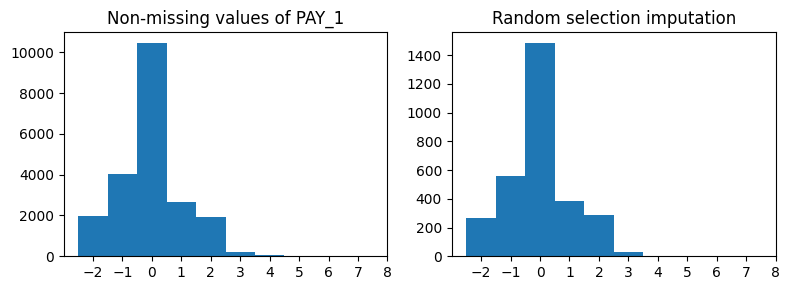

In [35]:
# visualizando se as distribuições da imputação aleatória são iguais aos valores de PAY_1
fig, axs = plt.subplots(1,2, figsize=(8,3))
bin_edges = np.arange(-2,9)
axs[0].hist(X_train[:,4], bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(fill_values[-1], bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Random selection imputation')
plt.tight_layout()

In [36]:
# fazendo validação cruzada sem busca na grade de hiper parâmetros
k_folds = KFold(n_splits=4, shuffle=True, random_state=1)

In [37]:
# instanciando o classificador com os melhores parametros encontrados
rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=9,
min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
max_leaf_nodes=None, min_impurity_decrease=0.0,
bootstrap=True, oob_score=False, n_jobs=None,
random_state=4, verbose=1, warm_start=False, class_weight=None)

In [38]:
for counter in range(len(fill_values)):
    #Copy the data frame with missing PAY_1 and assign imputed values
    df_fill_pay_1_filled = df_missing_pay_1.copy()
    df_fill_pay_1_filled['PAY_1'] = fill_values[counter]
    
    #Split imputed data in to training and testing, using the same
    #80/20 split we have used for the data with non-missing PAY_1
    X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
    train_test_split(
        df_fill_pay_1_filled[features_response[:-1]].values,
        df_fill_pay_1_filled['default payment next month'].values,
    test_size=0.2, random_state=24)
    
    #Concatenate the imputed data with the array of non-missing data
    X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
    y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
    
    #Use the KFolds splitter and the random forest model to get
    #4-fold cross-validation scores for both imputation methods
    imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
                                       cv=k_folds, n_jobs=-1, verbose=1,
                                       return_train_score=True, return_estimator=True,
                                       error_score='raise')
    
    test_score = imputation_compare_cv['test_score']
    print(fill_strategy[counter] + ' imputation: ' +
          'mean testing score ' + str(np.mean(test_score)) +
          ', std ' + str(np.std(test_score)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.2s
[Paralle

mode  imputation: mean testing score 0.772866246168149, std 0.0031479941297533737


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do

random  imputation: mean testing score 0.7692540439833129, std 0.003660875187678248


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.8s finished


1. A saída, nos permite concluir que as duas estratégias de imputação possuem desempenhos semelhantes [moda: 77,3% e random: 77,0%]. Contudo, a estratégia de imputação mais simples, de apenas preencher todos os valores faltantes com o vlaor mais comum (0) é a que tem melhor desempenho.
2. Entretanto o melhor desempenho ficou quando excluímos os valores faltantes do dataset (77,6%). Isso era esperado, já que agora estamos incluíndo dados que têm incertezas e problemas.

## 1.2 - Imputando modelo preditivo para PAY_1

1. Não consideramos PAY_1 como característica numérica, portanto, descartamos utilizar os algoritmos de Regressão.
2. Há mais de 2 valores para PAY_1, logo utilizaremos modelos de classificação multiclasse. 
3. Há duas abordagens onde se pode utilizar modelos de classificação binária, como a regressão logística para resolver problemas de classifição multiclasse: 1) um contra um e, 2) todos contra um.
4. Selecionamos a acurácia como métrica de desempenho do modelo, já que ela é um pouco mais fácil de usar com problemas multiclasse. Mas exitem maneiras de estender métricas como a ROC AUC para problemas multiclasse.

In [39]:
pay_1_df = df_removido_pay1.copy()

In [40]:
features_for_imputation = pay_1_df.columns.tolist()

In [41]:
items_to_remove_2 = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university', 'default payment next month', 'PAY_1']

In [42]:
features_for_imputation = [item for item in features_for_imputation if item not in items_to_remove_2]
features_for_imputation

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

1. Construindo um modelo de classificação multiclasse

In [43]:
X_impute_train, X_impute_test, y_impute_train, y_impute_test = \
train_test_split(
    pay_1_df[features_for_imputation].values,
    pay_1_df['PAY_1'].values,
test_size=0.2, random_state=24)

In [44]:
rf_impute_params = {
    'max_depth': [3, 6, 9, 12],
    'n_estimators':[10, 50, 100, 200]
}

In [45]:
cv_rf_impute = GridSearchCV(rf, param_grid=rf_impute_params, scoring='accuracy',
                            n_jobs=-1, refit=True,
                            cv=4, verbose=False, error_score=np.nan, return_train_score=True)

In [46]:
cv_rf_impute.fit(X_impute_train, y_impute_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=9, n_estimators=200,
                                              random_state=4, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=False)

In [47]:
impute_df = pd.DataFrame(cv_rf_impute.cv_results_)
impute_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.302209,0.009599,0.007949,0.000604,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.664729,0.669417,0.671479,0.664291,0.667479,0.003061,15,0.669396,0.670146,0.665146,0.670042,0.668682,0.002062
1,1.413394,0.093035,0.028688,0.002307,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.657979,0.660229,0.660604,0.651350,0.657540,0.003712,16,0.664521,0.657145,0.654082,0.660854,0.659150,0.003920
2,2.780812,0.147293,0.052302,0.011589,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.672605,0.673542,0.675792,0.667854,0.672448,0.002894,13,0.677835,0.675147,0.670521,0.676167,0.674918,0.002713
3,4.978688,0.142312,0.094838,0.009407,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.664917,0.666042,0.675792,0.666354,0.668276,0.004372,14,0.672334,0.668896,0.669021,0.672605,0.670714,0.001758
4,0.457608,0.013635,0.008074,0.000260,6,10,"{'max_depth': 6, 'n_estimators': 10}",0.710294,0.706919,0.713482,0.700675,0.707843,0.004744,12,0.717027,0.717027,0.718465,0.711607,0.716032,0.002621
5,2.391443,0.137109,0.038722,0.005800,6,50,"{'max_depth': 6, 'n_estimators': 50}",0.708419,0.709732,0.713107,0.703863,0.708780,0.003314,11,0.716652,0.716090,0.719777,0.715982,0.717125,0.001552
6,4.735327,0.307506,0.062690,0.007295,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.709544,0.709544,0.714420,0.705926,0.709859,0.003019,10,0.718777,0.716777,0.719152,0.718420,0.718282,0.000906
7,9.568024,0.401918,0.116514,0.004144,6,200,"{'max_depth': 6, 'n_estimators': 200}",0.710669,0.709357,0.715170,0.705551,0.710187,0.003436,9,0.719152,0.717652,0.719715,0.718107,0.718657,0.000818
8,0.661323,0.015970,0.010895,0.001972,9,10,"{'max_depth': 9, 'n_estimators': 10}",0.719670,0.725858,0.721920,0.720743,0.722048,0.002339,7,0.767721,0.773722,0.767221,0.771611,0.770069,0.002709
9,3.167740,0.057822,0.042628,0.000672,9,50,"{'max_depth': 9, 'n_estimators': 50}",0.726608,0.728296,0.725858,0.731808,0.728142,0.002293,6,0.770284,0.774347,0.771471,0.770611,0.771678,0.001601


In [48]:
cv_rf_impute.best_params_

{'max_depth': 12, 'n_estimators': 200}

In [49]:
cv_rf_impute.best_score_

np.float64(0.7344242187492307)

In [50]:
# examinando as contagens de valores de PAY_1 em pay_1_df e analisando a frequencia relativa
pay_1_value_counts = pay_1_df['PAY_1'].value_counts().sort_index()
pay_1_value_counts

PAY_1
-2     2476
-1     5047
 0    13087
 1     3261
 2     2378
 3      292
 4       63
 5       23
 6       11
 7        9
 8       17
Name: count, dtype: int64

In [51]:
pay_1_value_counts/pay_1_value_counts.sum()

PAY_1
-2    0.092859
-1    0.189281
 0    0.490812
 1    0.122300
 2    0.089184
 3    0.010951
 4    0.002363
 5    0.000863
 6    0.000413
 7    0.000338
 8    0.000638
Name: count, dtype: float64

In [52]:
# verificando se a acurácia da validação cruzada pode ser generalizada para o conjunto de testes
y_impute_predict = cv_rf_impute.predict(X_impute_test)
metrics.accuracy_score(y_impute_test, y_impute_predict)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


0.7391711981998875

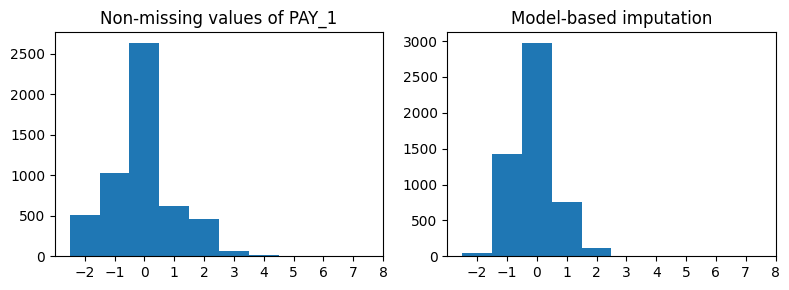

In [53]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].hist(y_impute_test, bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(y_impute_predict, bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Model-based imputation')
plt.tight_layout()

1. Verifica-se que usando a imputação pela moda, o esperado é que o valor da imputação esteja correto em 49% das vezes. E, usando imputação baseada em um modelo, está correto em 73,4% das vezes.
2. A acurácia no conjunto de testes é comparável com o conjunto de treinamento (73,9%).
3. A figura nos mostra que o modelo de imputação tem mais probabilidade de prever um valor 0 para PAY_1 do que deveria. No entanto, ele prevê outros valores e consequentemente é mais preciso que a imputação pela moda.

In [54]:
# coletando todos os valores com PAY_1 conhecido para treinar a versão final do modelo de imputação
X_impute_all = pay_1_df[features_for_imputation].values
y_impute_all = pay_1_df['PAY_1'].values

In [55]:
# instanciando o classificador com os melhores parametros encontrados
rf_impute = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=4)

In [56]:
# ajustando o modelo com todos os dados disponíveis
rf_impute.fit(X_impute_all, y_impute_all)

RandomForestClassifier(max_depth=12, n_estimators=200, random_state=4)

# Preenchendo os dados faltantes com o Modelo de Imputação

In [57]:
df_fill_pay_1_model = df_missing_pay_1.copy()

In [58]:
df_fill_pay_1_model['PAY_1'].head()

17    Not available
28    Not available
29    Not available
54    Not available
60    Not available
Name: PAY_1, dtype: object

In [59]:
df_fill_pay_1_model['PAY_1'] = rf_impute.predict(df_fill_pay_1_model[features_for_imputation].values)

In [60]:
df_fill_pay_1_model['PAY_1'].head()

17    0
28   -1
29    0
54    0
60    0
Name: PAY_1, dtype: int64

In [61]:
df_fill_pay_1_model['PAY_1'].value_counts().sort_index()

PAY_1
-2      30
-1     762
 0    1718
 1     443
 2      58
 3       7
 4       1
 6       1
 8       1
Name: count, dtype: int64

In [62]:
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_model[features_response[:-1]].values,
    df_fill_pay_1_model['default payment next month'].values,
test_size=0.2, random_state=24)

In [63]:
print(X_fill_pay_1_train.shape)
print(X_fill_pay_1_test.shape)
print(y_fill_pay_1_train.shape)
print(y_fill_pay_1_test.shape)

(2416, 17)
(605, 17)
(2416,)
(605,)


In [64]:
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
print(X_train_all.shape)
print(y_train_all.shape)

(23747, 17)
(23747,)


In [65]:
rf

RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4, verbose=1)

In [66]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
                                       cv=k_folds, n_jobs=-1, verbose=1,
                                       return_train_score=True, return_estimator=True,
                                       error_score='raise')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Paralle

In [67]:
imputation_compare_cv['test_score']

array([0.76885426, 0.77296923, 0.77127739, 0.77606362])

In [68]:
np.mean(imputation_compare_cv['test_score'])

np.float64(0.7722911233638938)

In [69]:
np.std(imputation_compare_cv['test_score'])

np.float64(0.0026235109358976796)

# Reatribuindo os valores de PAY_1 usando a Moda

In [70]:
df_fill_pay_1_model['PAY_1'] = np.zeros_like(df_fill_pay_1_model['PAY_1'].values)

In [71]:
df_fill_pay_1_model['PAY_1'].unique()

array([0])

In [72]:
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_model[features_response[:-1]].values,
    df_fill_pay_1_model['default payment next month'].values,
test_size=0.2, random_state=24)

In [73]:
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
X_test_all = np.concatenate((X_test, X_fill_pay_1_test), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
y_test_all = np.concatenate((y_test, y_fill_pay_1_test), axis=0)

In [74]:
print(X_train_all.shape)
print(X_test_all.shape)
print(y_train_all.shape)
print(y_test_all.shape)

(23747, 17)
(5938, 17)
(23747,)
(5938,)


In [75]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
                                       cv=k_folds, n_jobs=-1, verbose=1,
                                       return_train_score=True, return_estimator=True,
                                       error_score='raise')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    9.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Paralle

In [76]:
np.mean(imputation_compare_cv['test_score'])

np.float64(0.772866246168149)

# Confirmando a Performance do modelo nos dados de Teste

In [77]:
rf.fit(X_train_all, y_train_all)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.9s


RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4, verbose=1)

In [78]:
y_test_all_predict_proba = rf.predict_proba(X_test_all)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


In [79]:
# Previsões de probabilidade para o conjunto de teste
y_test_all_predict_proba = rf.predict_proba(X_test_all)

# Converter as probabilidades em classes (0 ou 1) com um threshold de 0.5
y_test_all_predict = (y_test_all_predict_proba[:, 1] >= 0.2).astype(int)  # Convertendo probabilidades para classes

# Calcular o ROC AUC
roc_auc = roc_auc_score(y_test_all, y_test_all_predict_proba[:, 1])
print("ROC AUC no conjunto de teste:", roc_auc)

# Matriz de Confusão
print("Matriz de Confusão:")
print(confusion_matrix(y_test_all, y_test_all_predict))

# Relatório de Classificação
print("Relatório de Classificação:")
print(classification_report(y_test_all, y_test_all_predict))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


ROC AUC no conjunto de teste: 0.7696243835824927
Matriz de Confusão:
[[3381 1272]
 [ 412  873]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      4653
           1       0.41      0.68      0.51      1285

    accuracy                           0.72      5938
   macro avg       0.65      0.70      0.65      5938
weighted avg       0.79      0.72      0.74      5938



[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


In [85]:
# criando array de possíveis limites 
thersholds = np.linspace(0, 1, 101)

In [88]:
df1[features_response[:-1]].columns[5]

'BILL_AMT1'

In [89]:
savings_per_default = np.mean(X_test_all[:, 5])
savings_per_default

np.float64(51601.7433479286)

In [90]:
cost_per_consulting = 7500
effectiveness = 0.70

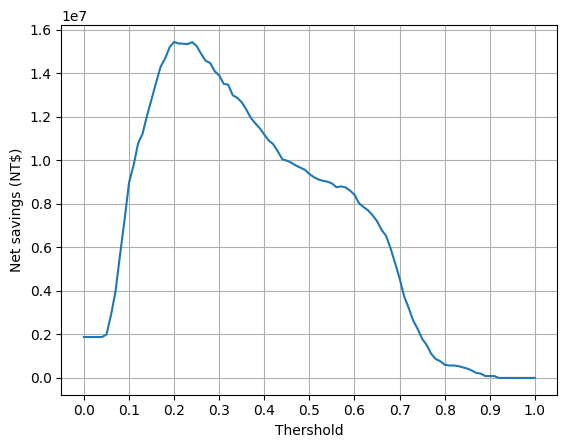

In [94]:
# Calculando os custos e a ecnomia para cada um dos limites
# criando arrays vazios para armazenar os resultados
n_pos_pred = np.empty_like(thersholds)
cost_of_all_consultings = np.empty_like(thersholds)
n_true_pos = np.empty_like(thersholds)
savings_of_all_consultings = np.empty_like(thersholds)
savings_based_on_balances = np.empty_like(thersholds)

# abrindo loop para percorrer os limites
counter = 0
for thershold in thersholds:
    pos_pred = y_test_all_predict_proba[:,1] > thershold # numero de inadimplencia prevista neste limite
    n_pos_pred[counter] = sum(pos_pred) # numero de previsões positivas neste limite
    cost_of_all_consultings[counter] = n_pos_pred[counter] * cost_per_consulting # calculo do custo de aconselhamento total
    true_pos = pos_pred & y_test_all.astype(bool) # numero de possiveis inadimplentes que foram aconselhados (verdadeiros positivos)
    n_true_pos[counter] = sum(true_pos) # numero de verdadeiros positivos com a soma do array de verdadeiros positivos
    savings_of_all_consultings[counter] = n_true_pos[counter] * savings_per_default * effectiveness # calculo da economia de aconselhamento efetivo
    counter += 1

net_savings = savings_of_all_consultings - cost_of_all_consultings # calculo da economia de aconselhamento total

plt.plot(thersholds, net_savings)
plt.xlabel('Thershold')
plt.ylabel('Net savings (NT$)')
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

In [95]:
# encontrando o índice do maior elemento do array de economias líquidas 
max_savings_ix = np.argmax(net_savings)

# exibindo o limite que resulta na maior economia líquida
thersholds[max_savings_ix]

np.float64(0.2)

In [96]:
# maior economia líquida possível
net_savings[max_savings_ix]

np.float64(15446325.35991916)

In [101]:
# custo de todas as inadimplências
cost_of_defaults = sum(y_test_all) * savings_per_default
cost_of_defaults

np.float64(66308240.202088244)

In [102]:
# diminuição da inadimplência pelo programa de aconselhamento 
net_savings[max_savings_ix]/cost_of_defaults

np.float64(0.2329472975431598)

In [103]:
# economia liquida por conta no limite máximo
net_savings[max_savings_ix]/len(y_test_all)

np.float64(2601.2673223171373)

Text(0, 0.5, 'Net savings per account (NT$)')

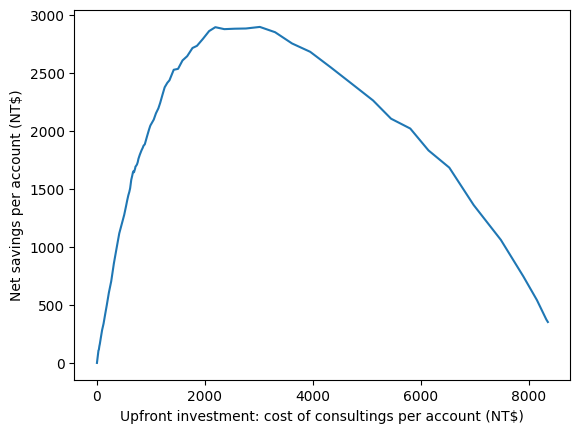

In [104]:
# plot da economia liquida por conta em relação ao custo do aconselhamento
plt.plot(cost_of_all_consultings/len(y_test), net_savings/len(y_test))
plt.xlabel('Upfront investment: cost of consultings per account (NT$)')
plt.ylabel('Net savings per account (NT$)')

Text(0.5, 0, 'Thershold')

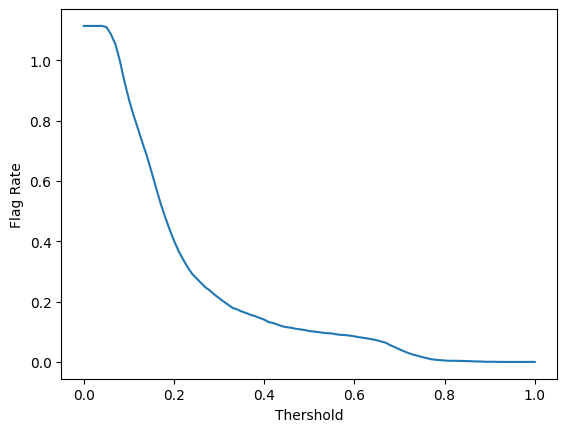

In [105]:
# fração de contas previstas como positivas em cada limite
plt.plot(thersholds, n_pos_pred/len(y_test))
plt.ylabel('Flag Rate')
plt.xlabel('Thershold')

1. O gráfico mostra que para começar a obter uma taxa de verdadeiros positivos (RECALL) muito acima de 0, temos de aceitar uma precisão perto de 0.75 ou mais baixa. Logo, parece haver espaço para a melhoria do modelo
2. Lembre-se: quanto mais precisas forem as previsões, menos dinheiro perderá em aconselhamentos devido a previsões incorretas. E, quanto mais alto o Recall, mais economia poderemos gerar identificando com sucesso contas que ficariam inadimplentes. 

/tmp/ipykernel_31384/4018275054.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(thersholds, np.divide(n_true_pos, n_pos_pred), label='Precision')


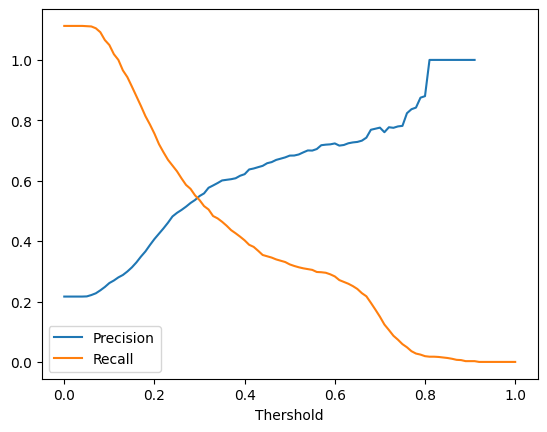

In [107]:
plt.plot(thersholds, np.divide(n_true_pos, n_pos_pred), label='Precision')
plt.plot(thersholds, n_true_pos/sum(y_test), label='Recall')
plt.xlabel('Thershold')
plt.legend()

/tmp/ipykernel_31384/1733299844.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(n_true_pos/sum(y_test), np.divide(n_true_pos, n_pos_pred))


Text(0, 0.5, 'Precision')

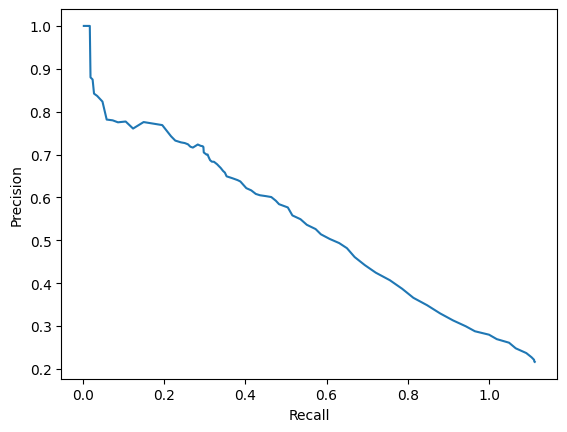

In [106]:
# curva precision-recall
plt.plot(n_true_pos/sum(y_test), np.divide(n_true_pos, n_pos_pred))
plt.xlabel('Recall')
plt.ylabel('Precision')

O melhor threshold é 0.20
Maior economia líquida possível: NT$ 15446325.36
Custo total das inadimplências: NT$ 66308240.20
Redução percentual da inadimplência: 23.29%
Economia líquida por conta: NT$ 2601.27


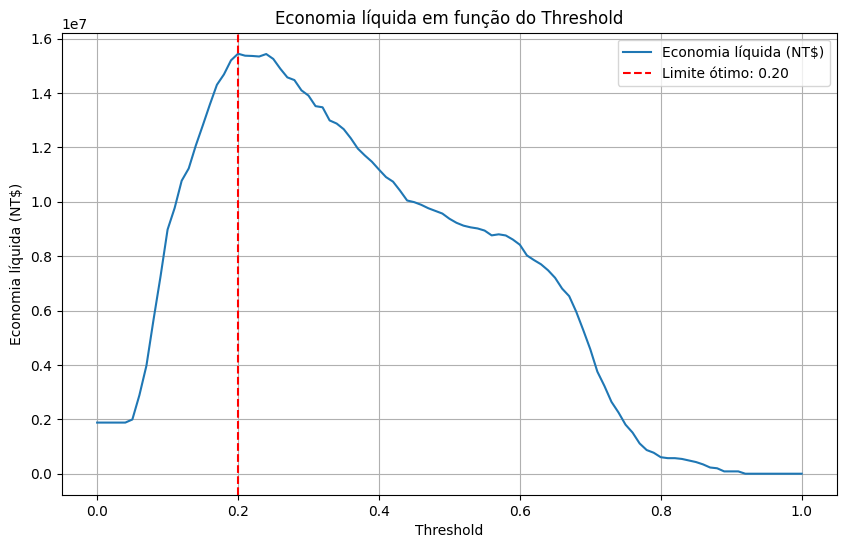

/tmp/ipykernel_31384/3866839011.py:78: RuntimeWarning: invalid value encountered in divide
  precision = n_true_pos / n_pos_pred


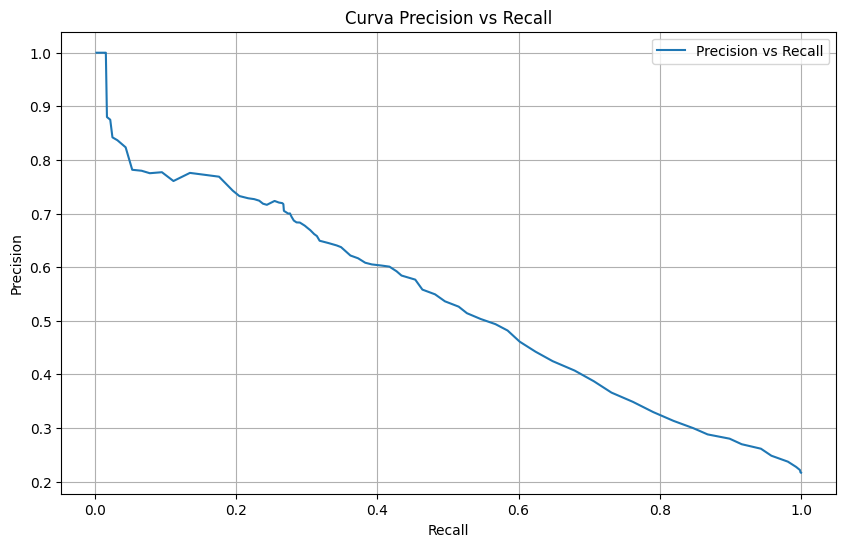

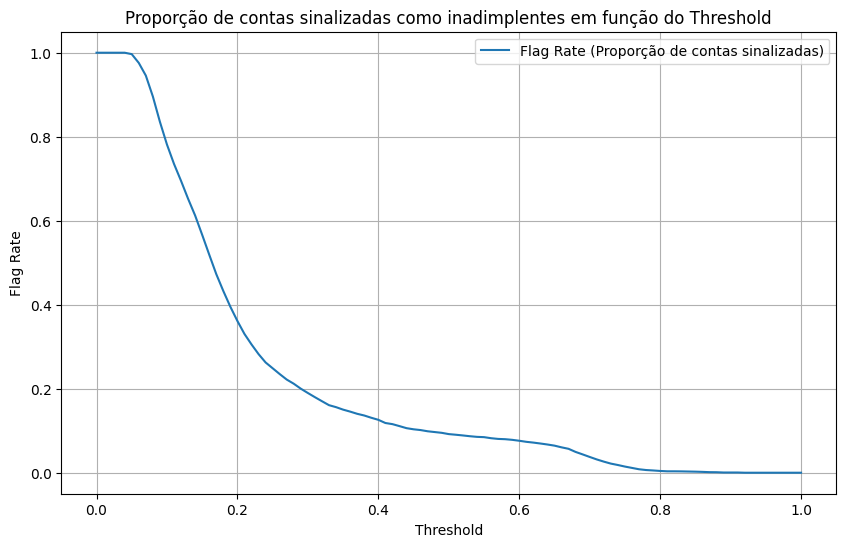

In [80]:
# ----- Análise Financeira -----
# Parâmetros fornecidos
cost_per_consulting = 7500  # Custo de cada sessão de aconselhamento
effectiveness = 0.70  # Taxa de sucesso do programa de aconselhamento

# Estimando o valor médio da fatura como a economia por inadimplência evitada
savings_per_default = np.mean(X_test_all[:, 5])

# Criando array de limites de probabilidade (thresholds)
thresholds = np.linspace(0, 1, 101)

# Arrays para armazenar resultados
n_pos_pred = np.zeros_like(thresholds)
cost_of_all_consultings = np.zeros_like(thresholds)
n_true_pos = np.zeros_like(thresholds)
savings_of_all_consultings = np.zeros_like(thresholds)
net_savings = np.zeros_like(thresholds)

# Loop pelos diferentes thresholds
for i, threshold in enumerate(thresholds):
    # Previsões positivas com base no threshold
    pos_pred = y_test_all_predict_proba[:,1] > threshold
    n_pos_pred[i] = pos_pred.sum()  # Número de previsões positivas (clientes para aconselhamento)

    # Cálculo do custo de todas as sessões de aconselhamento
    cost_of_all_consultings[i] = n_pos_pred[i] * cost_per_consulting

    # Verdadeiros positivos: clientes que foram corretamente previstos como inadimplentes
    true_pos = pos_pred & (y_test_all == 1)
    n_true_pos[i] = true_pos.sum()  # Número de verdadeiros positivos

    # Economia com base nas contas previstas corretamente como inadimplentes
    savings_of_all_consultings[i] = n_true_pos[i] * savings_per_default * effectiveness

    # Economia líquida: economia obtida menos o custo do programa
    net_savings[i] = savings_of_all_consultings[i] - cost_of_all_consultings[i]

# Encontrar o índice com a maior economia líquida
max_savings_ix = np.argmax(net_savings)

# Exibir o threshold que resulta na maior economia líquida
optimal_threshold = thresholds[max_savings_ix]
print(f"O melhor threshold é {optimal_threshold:.2f}")

# Exibir o valor da maior economia líquida possível
max_net_savings = net_savings[max_savings_ix]
print(f"Maior economia líquida possível: NT$ {max_net_savings:.2f}")

# ----- Cálculos Complementares -----

# Custo total de todas as inadimplências no conjunto de teste
cost_of_defaults = y_test_all.sum() * savings_per_default
print(f"Custo total das inadimplências: NT$ {cost_of_defaults:.2f}")

# Percentual de diminuição da inadimplência com o programa
percentage_reduction = max_net_savings / cost_of_defaults * 100
print(f"Redução percentual da inadimplência: {percentage_reduction:.2f}%")

# Economia líquida por conta servida
net_savings_per_account = max_net_savings / len(y_test_all)
print(f"Economia líquida por conta: NT$ {net_savings_per_account:.2f}")

# ----- Gráficos -----

# Plot da economia líquida por threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, net_savings, label="Economia líquida (NT$)")
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f"Limite ótimo: {optimal_threshold:.2f}")
plt.xlabel('Threshold')
plt.ylabel('Economia líquida (NT$)')
plt.title('Economia líquida em função do Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de Precisão vs Recall
plt.figure(figsize=(10, 6))
precision = n_true_pos / n_pos_pred
recall = n_true_pos / sum(y_test_all)

plt.plot(recall, precision, label='Precision vs Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision vs Recall')
plt.legend()
plt.grid(True)
plt.show()

# Flag Rate: proporção de contas sinalizadas como inadimplentes por threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, n_pos_pred / len(y_test_all), label='Flag Rate (Proporção de contas sinalizadas)')
plt.xlabel('Threshold')
plt.ylabel('Flag Rate')
plt.title('Proporção de contas sinalizadas como inadimplentes em função do Threshold')
plt.legend()
plt.grid(True)
plt.show()

Text(0, 0.5, 'Number of accounts')

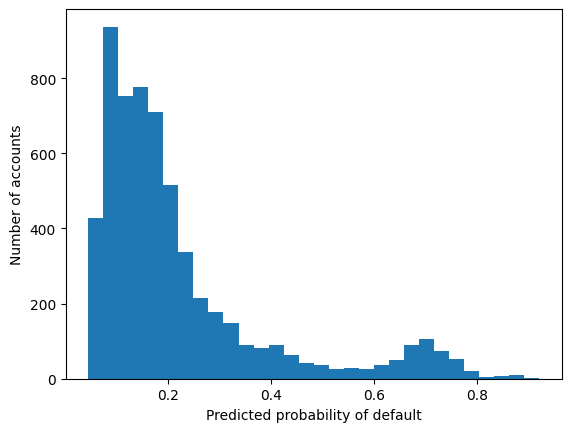

In [81]:
# monitorando a implementação do modelo
# verificar se a natureza das previsões está mudando com o tempo, em comparação com a população usada no treinamento do modelo.
plt.hist(y_test_all_predict_proba[:, 1], bins=30)
plt.xlabel('Predicted probability of default')
plt.ylabel('Number of accounts')